# 📊 Notebook 4 - Agrégation et Visualisations

Ce notebook agrège les résultats et crée des visualisations.

## Objectifs
1. Agréger les événements par livre
2. Normaliser par 100 pages / 10k mots
3. Comparer les prises de parole
4. Créer des graphiques
5. Exporter CSV et PNG

## Entrées
- `data/events.parquet` : événements détectés
- `data/book_metadata.json` : métadonnées

## Sorties
- `outputs/agg_by_book.csv` : statistiques agrégées
- `outputs/*.png` : graphiques

In [1]:
# Imports
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Configuration
NOTEBOOK_DIR = Path().absolute()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

OUTPUT_DIR.mkdir(exist_ok=True)

# Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"📁 Data: {DATA_DIR}")
print(f"📁 Outputs: {OUTPUT_DIR}")

📁 Data: c:\Users\julie\src\School\Workshop\workshop-poudlard-epsi\projects\22-proces-jk-rowling\hp_nlp\data
📁 Outputs: c:\Users\julie\src\School\Workshop\workshop-poudlard-epsi\projects\22-proces-jk-rowling\hp_nlp\outputs


In [2]:
# Charger les données
df = pd.read_parquet(DATA_DIR / 'events.parquet')
with open(DATA_DIR / 'book_metadata.json', 'r', encoding='utf-8') as f:
    metadata = json.load(f)

print(f"📊 Données: {df.shape}")
print(f"📚 Livres: {len(metadata['books'])}")

📊 Données: (58654, 21)
📚 Livres: 7


## 1. Agrégation par livre

In [3]:
# Créer DataFrame d'agrégation
agg_data = []

for book in metadata['books']:
    book_df = df[df['book_number'] == book['book_number']]
    
    # Statistiques brutes
    stats = {
        'book_number': book['book_number'],
        'title': book['title'],
        'pages': book['pages'],
        'word_count': book['word_count'],
        'sentences': len(book_df),
        
        # Événements
        'scar_touches': book_df['event_scar_touch'].sum(),
        'hermione_mais': book_df['event_hermione_mais_count'].sum(),
        'dumbledore_interventions': book_df['event_dumbledore_intervention'].sum(),
        'snape_mysterious': book_df['event_snape_dark'].sum(),
        'questionable_acts': book_df['event_questionable_act'].sum(),
        
        # Dialogues
        'dialogues_total': book_df['is_dialogue'].sum(),
        'dialogues_harry': (book_df['speaker'] == 'Harry').sum(),
        'dialogues_hermione': (book_df['speaker'] == 'Hermione').sum(),
        'dialogues_ron': (book_df['speaker'] == 'Ron').sum(),
    }
    
    agg_data.append(stats)

df_agg = pd.DataFrame(agg_data)

print("📊 Agrégation brute:")
print(df_agg[['title', 'scar_touches', 'hermione_mais', 'dumbledore_interventions', 'snape_mysterious', 'questionable_acts']])

📊 Agrégation brute:
                     title  scar_touches  hermione_mais  \
0     L'École des Sorciers             4             19   
1   La Chambre des Secrets             1             33   
2  Le Prisonnier d'Azkaban             1             52   
3          La Coupe de Feu            17             77   
4        L'Ordre du Phénix            19            178   
5   Le Prince de Sang-Mêlé             1             59   
6  Les Reliques de la Mort            45            161   

   dumbledore_interventions  snape_mysterious  questionable_acts  
0                         2                 2                166  
1                         4                 5                172  
2                         2                 5                195  
3                         5                 7                315  
4                         6                10                468  
5                        13                 7                297  
6                        10           

## 2. Normalisation

In [4]:
# Normalisation par 100 pages
df_agg['scar_per_100p'] = (df_agg['scar_touches'] / df_agg['pages']) * 100
df_agg['mais_per_100p'] = (df_agg['hermione_mais'] / df_agg['pages']) * 100
df_agg['dumb_per_100p'] = (df_agg['dumbledore_interventions'] / df_agg['pages']) * 100
df_agg['snape_per_100p'] = (df_agg['snape_mysterious'] / df_agg['pages']) * 100
df_agg['acts_per_100p'] = (df_agg['questionable_acts'] / df_agg['pages']) * 100

# Normalisation par 10k mots
df_agg['scar_per_10k'] = (df_agg['scar_touches'] / df_agg['word_count']) * 10000
df_agg['mais_per_10k'] = (df_agg['hermione_mais'] / df_agg['word_count']) * 10000
df_agg['dumb_per_10k'] = (df_agg['dumbledore_interventions'] / df_agg['word_count']) * 10000
df_agg['snape_per_10k'] = (df_agg['snape_mysterious'] / df_agg['word_count']) * 10000
df_agg['acts_per_10k'] = (df_agg['questionable_acts'] / df_agg['word_count']) * 10000

print("\n📊 Statistiques normalisées (par 100 pages):")
print(df_agg[['title', 'scar_per_100p', 'mais_per_100p', 'dumb_per_100p', 'snape_per_100p', 'acts_per_100p']].round(2))


📊 Statistiques normalisées (par 100 pages):
                     title  scar_per_100p  mais_per_100p  dumb_per_100p  \
0     L'École des Sorciers           1.25           5.94           0.62   
1   La Chambre des Secrets           0.28           9.17           1.11   
2  Le Prisonnier d'Azkaban           0.24          12.38           0.48   
3          La Coupe de Feu           2.59          11.74           0.76   
4        L'Ordre du Phénix           1.94          18.16           0.61   
5   Le Prince de Sang-Mêlé           0.16           9.22           2.03   
6  Les Reliques de la Mort           5.62          20.12           1.25   

   snape_per_100p  acts_per_100p  
0            0.62          51.88  
1            1.39          47.78  
2            1.19          46.43  
3            1.07          48.02  
4            1.02          47.76  
5            1.09          46.41  
6            0.62          46.75  


## 3. Visualisations

✅ Graphique sauvegardé: events_evolution.png


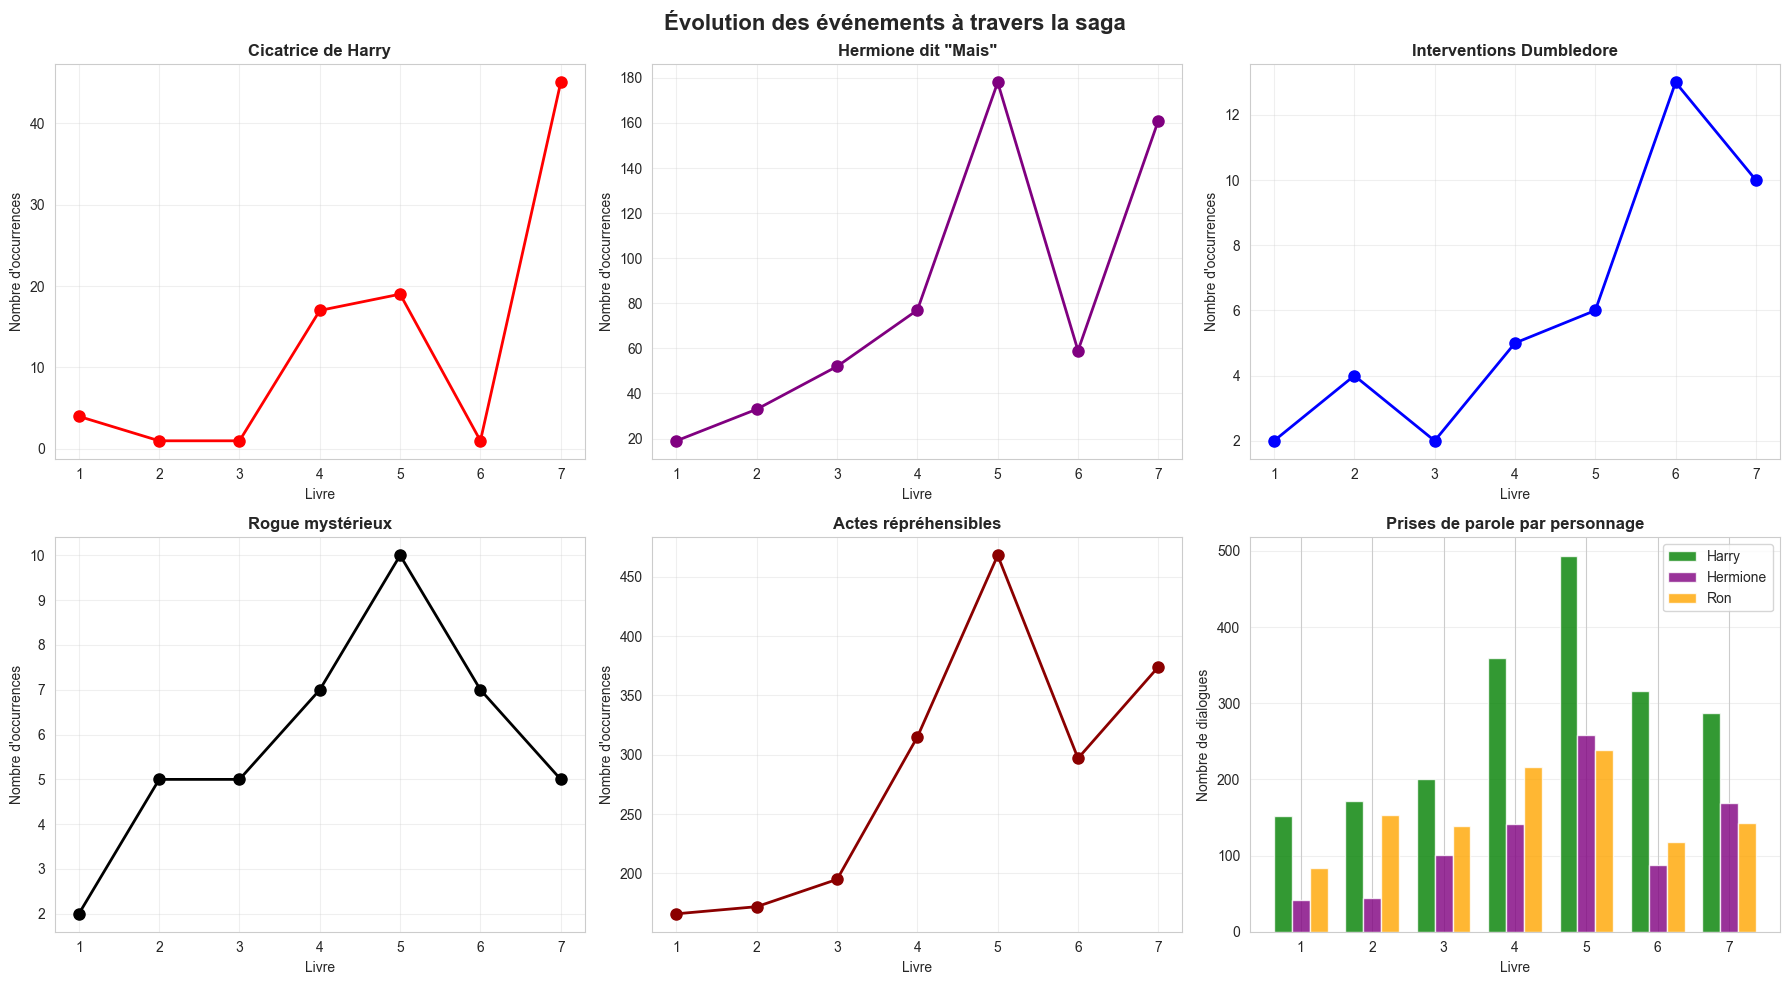

In [5]:
# 1. Évolution des événements par livre (valeurs brutes)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Évolution des événements à travers la saga', fontsize=16, fontweight='bold')

metrics = [
    ('scar_touches', 'Cicatrice de Harry', 'red', axes[0, 0]),
    ('hermione_mais', 'Hermione dit "Mais"', 'purple', axes[0, 1]),
    ('dumbledore_interventions', 'Interventions Dumbledore', 'blue', axes[0, 2]),
    ('snape_mysterious', 'Rogue mystérieux', 'black', axes[1, 0]),
    ('questionable_acts', 'Actes répréhensibles', 'darkred', axes[1, 1]),
]

for metric, title, color, ax in metrics:
    ax.plot(df_agg['book_number'], df_agg[metric], marker='o', color=color, linewidth=2, markersize=8)
    ax.set_xlabel('Livre')
    ax.set_ylabel('Nombre d\'occurrences')
    ax.set_title(title, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(df_agg['book_number'])

# Graphique de comparaison des dialogues
ax = axes[1, 2]
x = df_agg['book_number']
width = 0.25
ax.bar(x - width, df_agg['dialogues_harry'], width, label='Harry', color='green', alpha=0.8)
ax.bar(x, df_agg['dialogues_hermione'], width, label='Hermione', color='purple', alpha=0.8)
ax.bar(x + width, df_agg['dialogues_ron'], width, label='Ron', color='orange', alpha=0.8)
ax.set_xlabel('Livre')
ax.set_ylabel('Nombre de dialogues')
ax.set_title('Prises de parole par personnage', fontweight='bold')
ax.legend()
ax.set_xticks(df_agg['book_number'])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'events_evolution.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé: events_evolution.png")
plt.show()

✅ Graphique sauvegardé: normalized_stats.png


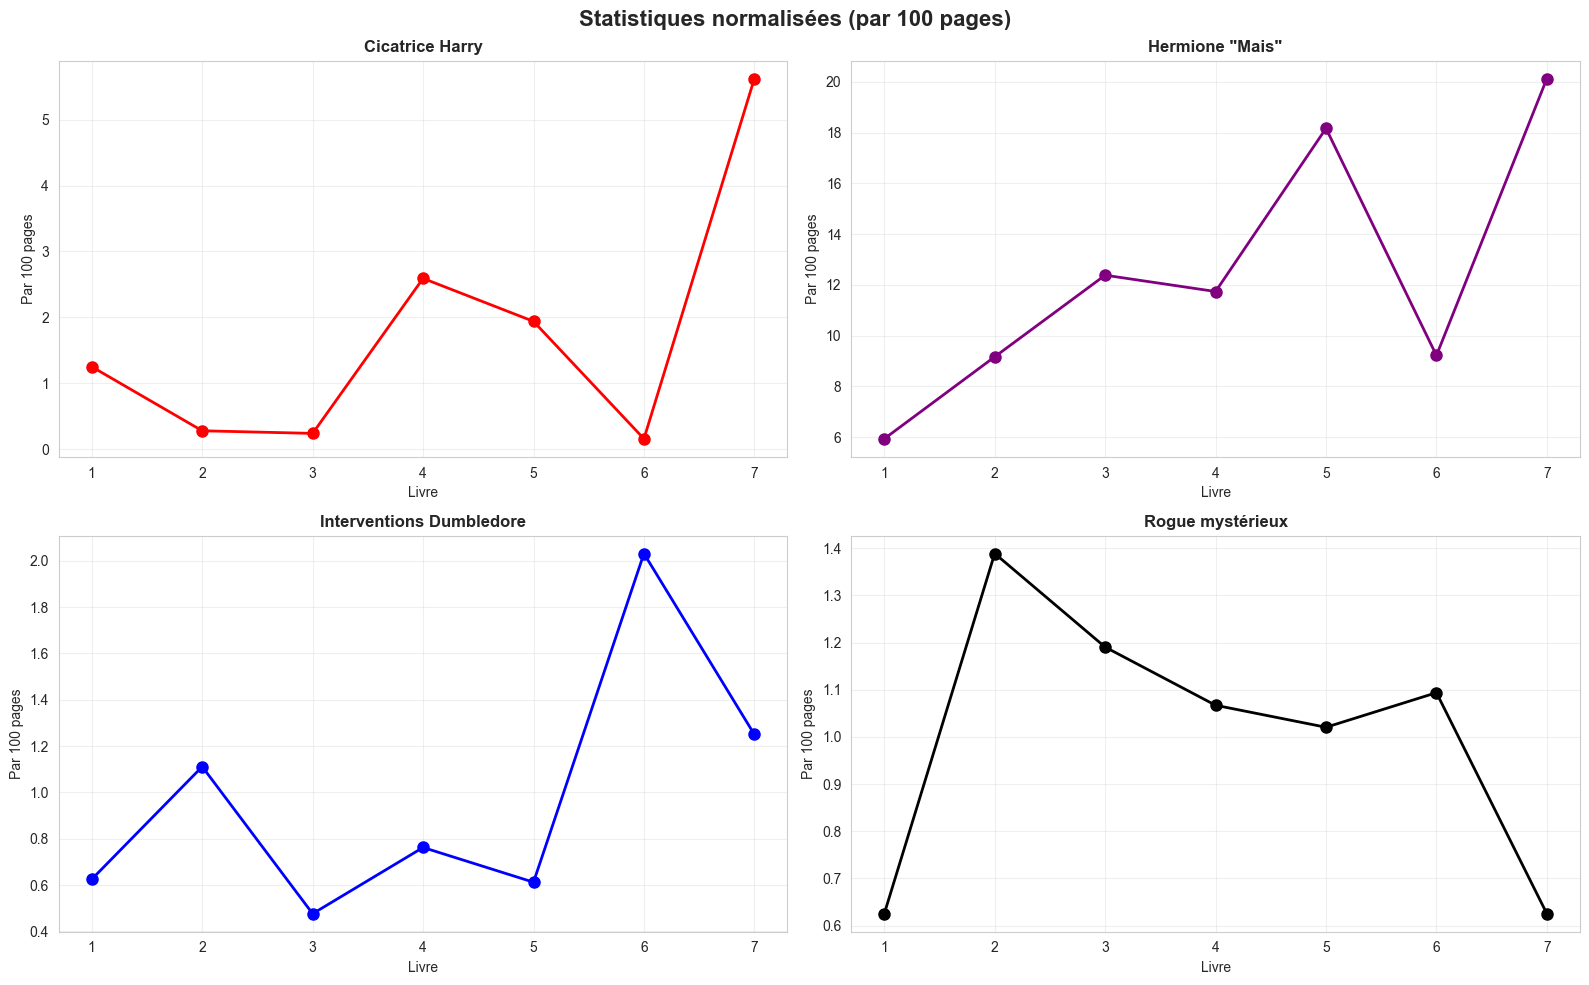

In [6]:
# 2. Statistiques normalisées (par 100 pages)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Statistiques normalisées (par 100 pages)', fontsize=16, fontweight='bold')

norm_metrics = [
    ('scar_per_100p', 'Cicatrice Harry', 'red', axes[0, 0]),
    ('mais_per_100p', 'Hermione "Mais"', 'purple', axes[0, 1]),
    ('dumb_per_100p', 'Interventions Dumbledore', 'blue', axes[1, 0]),
    ('snape_per_100p', 'Rogue mystérieux', 'black', axes[1, 1]),
]

for metric, title, color, ax in norm_metrics:
    ax.plot(df_agg['book_number'], df_agg[metric], marker='o', color=color, linewidth=2, markersize=8)
    ax.set_xlabel('Livre')
    ax.set_ylabel('Par 100 pages')
    ax.set_title(title, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(df_agg['book_number'])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'normalized_stats.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé: normalized_stats.png")
plt.show()

✅ Graphique sauvegardé: heatmap_events.png


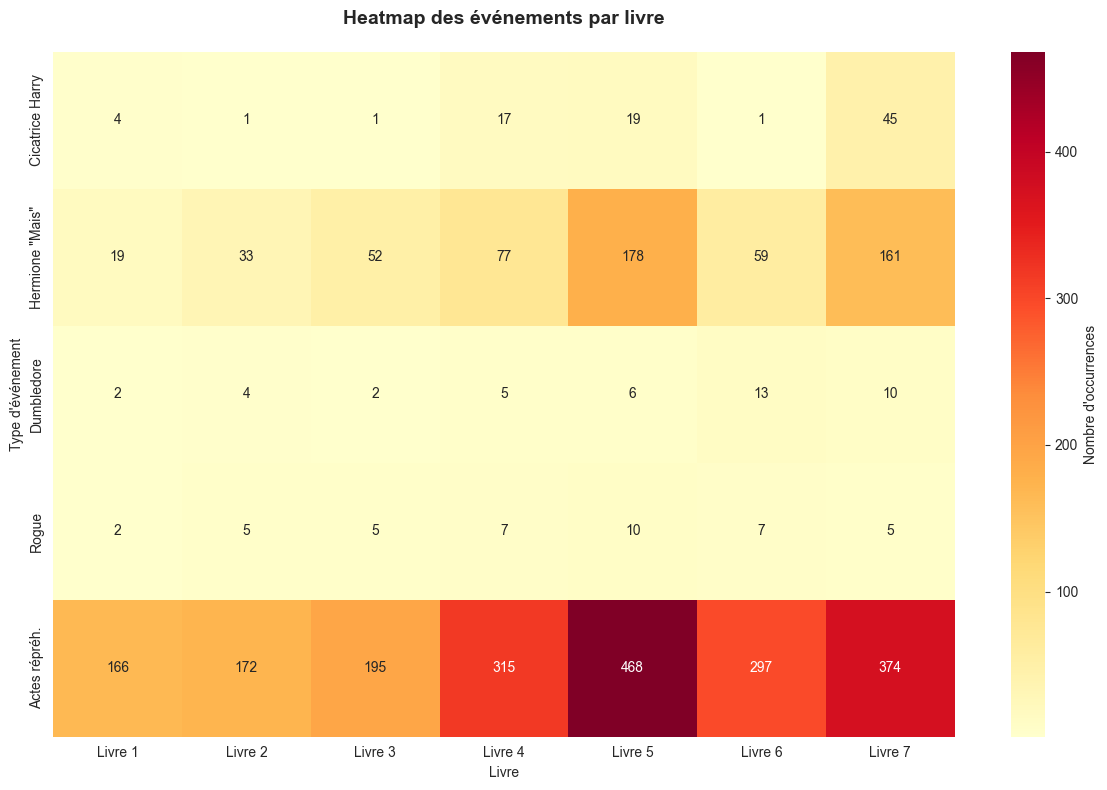

In [7]:
# 3. Heatmap de toutes les statistiques
plt.figure(figsize=(12, 8))

# Sélectionner les colonnes numériques importantes
heatmap_cols = ['scar_touches', 'hermione_mais', 'dumbledore_interventions', 
                'snape_mysterious', 'questionable_acts']
heatmap_data = df_agg[heatmap_cols].T
heatmap_data.columns = [f"Livre {i}" for i in df_agg['book_number']]

# Renommer les lignes
heatmap_data.index = ['Cicatrice Harry', 'Hermione "Mais"', 'Dumbledore', 'Rogue', 'Actes répréh.']

sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Nombre d\'occurrences'})
plt.title('Heatmap des événements par livre', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Type d\'événement')
plt.xlabel('Livre')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'heatmap_events.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé: heatmap_events.png")
plt.show()

✅ Graphique sauvegardé: dialogues_comparison.png


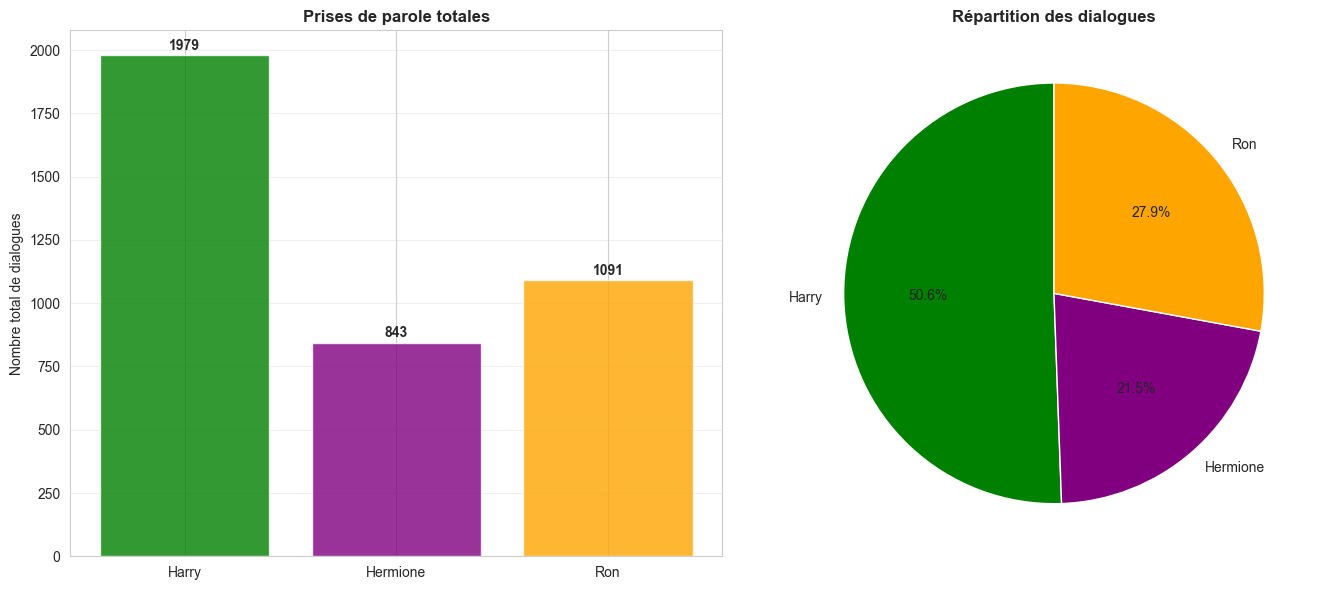


🏆 Le plus bavard: Harry avec 1979 dialogues!


In [8]:
# 4. Comparaison des dialogues (totaux sur la saga)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Total par personnage
characters = ['Harry', 'Hermione', 'Ron']
totals = [
    df_agg['dialogues_harry'].sum(),
    df_agg['dialogues_hermione'].sum(),
    df_agg['dialogues_ron'].sum()
]
colors = ['green', 'purple', 'orange']

ax1.bar(characters, totals, color=colors, alpha=0.8)
ax1.set_ylabel('Nombre total de dialogues')
ax1.set_title('Prises de parole totales', fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Valeurs sur les barres
for i, v in enumerate(totals):
    ax1.text(i, v + 10, str(v), ha='center', va='bottom', fontweight='bold')

# Diagramme circulaire
ax2.pie(totals, labels=characters, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Répartition des dialogues', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dialogues_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé: dialogues_comparison.png")
plt.show()

print(f"\n🏆 Le plus bavard: {characters[totals.index(max(totals))]} avec {max(totals)} dialogues!")

## 4. Export des résultats

In [9]:
# Export CSV
csv_path = OUTPUT_DIR / 'agg_by_book.csv'
df_agg.to_csv(csv_path, index=False, encoding='utf-8')
print(f"✅ CSV exporté: {csv_path}")

# Export JSON pour le rapport
json_path = OUTPUT_DIR / 'agg_by_book.json'
df_agg.to_json(json_path, orient='records', indent=2, force_ascii=False)
print(f"✅ JSON exporté: {json_path}")

✅ CSV exporté: c:\Users\julie\src\School\Workshop\workshop-poudlard-epsi\projects\22-proces-jk-rowling\hp_nlp\outputs\agg_by_book.csv
✅ JSON exporté: c:\Users\julie\src\School\Workshop\workshop-poudlard-epsi\projects\22-proces-jk-rowling\hp_nlp\outputs\agg_by_book.json


In [10]:
# Créer un résumé textuel
summary = f"""# Résumé de l'analyse Harry Potter

## Statistiques globales (7 livres)

- **Total phrases analysées**: {len(df):,}
- **Total mots**: {df_agg['word_count'].sum():,}
- **Total pages**: {df_agg['pages'].sum():,}

## Événements détectés

- **Cicatrice de Harry**: {df_agg['scar_touches'].sum()}
- **Hermione dit "Mais"**: {df_agg['hermione_mais'].sum()}
- **Interventions Dumbledore**: {df_agg['dumbledore_interventions'].sum()}
- **Rogue mystérieux**: {df_agg['snape_mysterious'].sum()}
- **Actes répréhensibles**: {df_agg['questionable_acts'].sum()}

## Dialogues

- **Harry**: {df_agg['dialogues_harry'].sum()}
- **Hermione**: {df_agg['dialogues_hermione'].sum()}
- **Ron**: {df_agg['dialogues_ron'].sum()}

🏆 **Le plus bavard**: {characters[totals.index(max(totals))]} avec {max(totals)} dialogues!

## Tendances

- Les actes répréhensibles augmentent considérablement dans les livres 4-7
- Rogue devient plus mystérieux au fil de la saga
- Harry touche sa cicatrice de plus en plus fréquemment (signe de danger croissant)
"""

summary_path = OUTPUT_DIR / 'summary.md'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"\n✅ Résumé exporté: {summary_path}")
print("\n" + "="*70)
print(summary)
print("="*70)


✅ Résumé exporté: c:\Users\julie\src\School\Workshop\workshop-poudlard-epsi\projects\22-proces-jk-rowling\hp_nlp\outputs\summary.md

# Résumé de l'analyse Harry Potter

## Statistiques globales (7 livres)

- **Total phrases analysées**: 58,654
- **Total mots**: 1,240,932
- **Total pages**: 4,176

## Événements détectés

- **Cicatrice de Harry**: 88
- **Hermione dit "Mais"**: 579
- **Interventions Dumbledore**: 42
- **Rogue mystérieux**: 41
- **Actes répréhensibles**: 1987

## Dialogues

- **Harry**: 1979
- **Hermione**: 843
- **Ron**: 1091

🏆 **Le plus bavard**: Harry avec 1979 dialogues!

## Tendances

- Les actes répréhensibles augmentent considérablement dans les livres 4-7
- Rogue devient plus mystérieux au fil de la saga
- Harry touche sa cicatrice de plus en plus fréquemment (signe de danger croissant)



## ✅ Résumé

Ce notebook a:
1. ✅ Agrégé les événements par livre
2. ✅ Normalisé les statistiques par 100 pages et 10k mots
3. ✅ Comparé les prises de parole
4. ✅ Créé 4 graphiques de qualité
5. ✅ Exporté les résultats en CSV/JSON

**Fichiers générés:**
- `agg_by_book.csv` : données agrégées
- `events_evolution.png` : évolution des événements
- `normalized_stats.png` : statistiques normalisées
- `heatmap_events.png` : heatmap complète
- `dialogues_comparison.png` : comparaison des dialogues
- `summary.md` : résumé textuel

**Prochaine étape**: Notebook 05 - Génération du rapport méthodologique